In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
team_feats = pd.read_csv("../data/team_feats.csv")
games = pd.read_csv("../data/games.csv")

In [3]:
games=games[games['season']>=2017].copy()

In [4]:
team_feats = pd.DataFrame(np.where(team_feats==0,np.nan,team_feats),
                    columns=team_feats.columns,
                    index=team_feats.index)

In [5]:
home_feats = team_feats.copy()
home_feats.columns = ['home_'+i for i in home_feats.columns]
home_feats.rename(mapper={'home_season':'season'},axis=1,inplace=True)

away_feats = team_feats.copy()
away_feats.columns = ['away_'+i for i in away_feats.columns]
away_feats.rename(mapper={'away_season':'season'},axis=1,inplace=True)

In [258]:
merge = games.merge(home_feats,on=['season','home_team'],how='left').merge(away_feats,on=['season','away_team'],how='left')

for col in [
        i for i in home_feats.columns if i not in ('season','home_team')
    ]:
    other_col = col.replace('home_','away_')
    new_col = col.replace('home_','diff_')
    merge[new_col] = merge[col] - merge[other_col]

all_feats = [
    i for i in home_feats.columns if i not in ('season','home_team')
] + [
    i for i in away_feats.columns if i not in ('season','away_team')
] + [
    i for i in merge.columns if 'diff_' in i
] + ['flg']
target = 'outcome' 
target1 = 'result'

merge['outcome'] = merge['result'] - merge['spread_line']

merge['outcome_hm_beat'] = np.where(merge['outcome']>0,1,0)

merge=merge.copy()
merge['flg'] = 1

merge[all_feats] = merge[all_feats].fillna(0)

val_season = 2023
train_seasons = list(range(2017,val_season))


train = merge[merge['season'].isin(train_seasons)].copy()
val = merge[merge['season']==val_season]

meandiff = abs(train[train[target]<0][all_feats].mean()/
 train[train[target]>0][all_feats].mean() )
f1 = list(meandiff.sort_values().tail(20).index)
f2 = list(meandiff.sort_values().head(0).index)

feats = ['flg']+f1+f2

In [259]:
merge[['spread_line','result','outcome','outcome_hm_beat']]

,spread_line,result,outcome,outcome_hm_beat
0,8.0,-15.0,-23.0,0
1,7.0,9.0,2.0,1
2,-6.5,-6.0,0.5,1
3,2.5,-20.0,-22.5,0
4,-10.0,-3.0,7.0,1
...,...,...,...,...
2191,NaN,NaN,NaN,0
2192,NaN,NaN,NaN,0
2193,NaN,NaN,NaN,0
2194,NaN,NaN,NaN,0


In [260]:
Xtrain = train[feats].copy()
ytrain = train[target].copy()
Xval = val[feats].copy()
yval = val[target].copy()

In [261]:
corrs = train[all_feats+[target]].corr()[target].sort_values()

corrs[(abs(corrs)>.03)&(abs(corrs)<1)]

home_rushing_fumbles_lost      -0.065918
away_special_teams_tds         -0.060133
diff_passing_air_yards         -0.043850
diff_attempts                  -0.041670
diff_completions               -0.040821
away_sacks                     -0.040036
diff_rushing_fumbles           -0.039239
diff_interceptions             -0.037258
home_receiving_fumbles_lost    -0.035825
diff_receiving_air_yards       -0.034664
diff_passing_yards             -0.034645
home_passing_2pt_conversions   -0.032309
home_attempts                  -0.031752
diff_passing_first_downs       -0.031314
away_sack_yards                -0.030746
away_rushing_fumbles_lost      -0.030012
away_completions                0.030555
away_passing_first_downs        0.031002
diff_sacks                      0.031885
away_passing_air_yards          0.032274
home_rushing_yards              0.033284
away_rushing_fumbles            0.033616
away_receiving_air_yards        0.034400
home_carries                    0.034963
away_interceptio

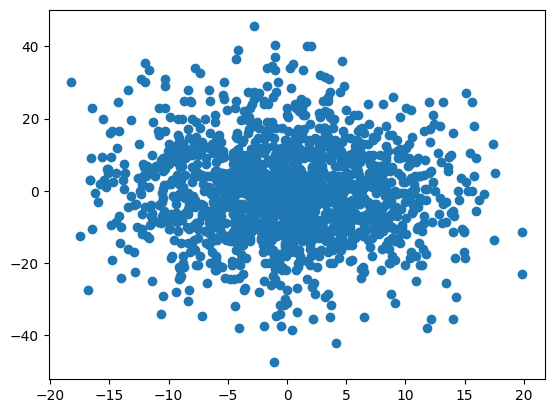

In [262]:
plt.scatter(train['diff_receiving_air_yards'],train['outcome'])

In [417]:
from sklearn.feature_selection import SelectKBest,f_regression,VarianceThreshold,f_classif,SequentialFeatureSelector
from sklearn.preprocessing import PolynomialFeatures,StandardScaler,QuantileTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score,accuracy_score

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor,StackingRegressor,RandomForestClassifier
from sklearn.linear_model import Ridge,LinearRegression,LogisticRegression,Lasso,ElasticNet
from sklearn.neighbors import KNeighborsRegressor,KNeighborsClassifier
from sklearn.svm import NuSVR,SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.compose import TransformedTargetRegressor



In [525]:
r1 = RandomForestRegressor(
    random_state=42,
    n_estimators=250,
    #min_samples_leaf=5
    max_features=.63,
    max_samples=.63,
    max_depth=5,
    min_samples_split=2,
    min_samples_leaf=1,
    n_jobs=-1
)
r1 = XGBRegressor(
    random_state=42,
    n_jobs=-1,
    max_depth=6
)
r1 = LinearRegression(fit_intercept=False)
r1 = Lasso(fit_intercept=False,alpha=10)
r1 = ElasticNet(fit_intercept=False,alpha=10)
r1 = Ridge(fit_intercept=False,alpha=10)

model = Pipeline(
    steps=[
        ('poly',PolynomialFeatures(degree = (1,2))),
        #('thresh',VarianceThreshold(0)),
        #('scaler',StandardScaler()),
        #('selector',SelectKBest(score_func=f_classif,k=25)),
        #('selector',SequentialFeatureSelector(r35,n_features_to_select=20,n_jobs=-1)),
        ('learner',r1)
    ]
)

In [526]:
model.fit(Xtrain,ytrain)

Pipeline(steps=[('poly', PolynomialFeatures(degree=(1, 2))),
                ('learner', KNeighborsRegressor())])

In [527]:
yfit = pd.Series(model.predict(Xtrain),index=Xtrain.index)
ypred = pd.Series(model.predict(Xval),index=Xval.index)

In [528]:
def r2_score_mod(ytrue,ypred,ytrain):

    return 1-sum((ytrue - ypred)**2)/sum((ytrue - ytrain.mean())**2)

In [529]:
r2_score_mod(yval,ypred,ytrain)

-0.13219268617704616

In [530]:
r2_score_mod(ytrain,yfit,ytrain)

0.21009154566855215

In [531]:
results = pd.DataFrame(np.where((yval>0)&(ypred>0),'tp',
    np.where((yval<0)&(ypred<0),'tn',
    np.where((yval<0)&(ypred>0),'fp',
    np.where((yval>0)&(ypred<0),'fn','other'
         )))),columns=['res'])
results['cnt'] = 1
print(results.groupby(['res'])['cnt'].count())#/sum(results[results['res']!='other']['cnt']))
print(results.groupby(['res'])['cnt'].count()[['tn','tp']].sum() - results.groupby(['res'])['cnt'].count()[['fn','fp']].sum() )
print(results.groupby(['res'])['cnt'].count()[['fp','tp']].sum() - results.groupby(['res'])['cnt'].count()[['fn','tn']].sum() )

res
fn       66
fp       65
other    15
tn       71
tp       68
Name: cnt, dtype: int64
8
-4


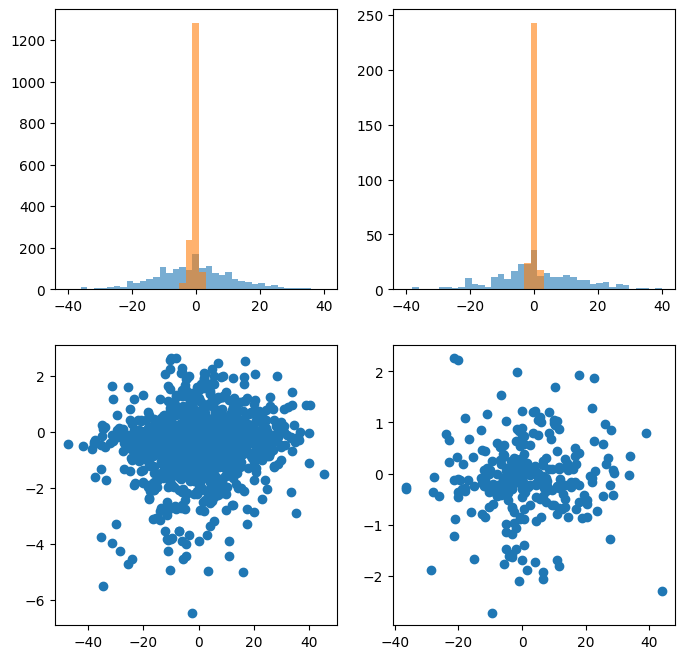

In [502]:
fig,axs = plt.subplots(2,2,figsize=(8,8))

axs[0,0].hist(ytrain,bins=np.linspace(-40,40,40),alpha=.6)
axs[0,0].hist(yfit,bins=np.linspace(-40,40,40),alpha=.6)
axs[0,1].hist(yval,bins=np.linspace(-40,40,40),alpha=.6)
axs[0,1].hist(ypred,bins=np.linspace(-40,40,40),alpha=.6)

axs[1,0].scatter(ytrain,yfit)

axs[1,1].scatter(yval,ypred)
plt.show()


In [255]:
from sklearn.tree import plot_tree,export_text
"""
treemod = model['learner']

# Plot the decision tree
plt.figure(figsize=(20,8))
plot_tree(treemod, filled=True, feature_names=list(treemod.feature_names_in_),fontsize=12)
plt.show()

tree_text = export_text(treemod, feature_names=list(treemod.feature_names_in_))
print(tree_text)"""


"\ntreemod = model['learner']\n\n# Plot the decision tree\nplt.figure(figsize=(20,8))\nplot_tree(treemod, filled=True, feature_names=list(treemod.feature_names_in_),fontsize=12)\nplt.show()\n\ntree_text = export_text(treemod, feature_names=list(treemod.feature_names_in_))\nprint(tree_text)"

In [102]:
(ypred==yval).mean()

0.0

In [103]:
(yfit==ytrain).mean()

0.0

In [ ]:
accuracy_score(y_true=yval,y_pred=ypred)

In [257]:
results = pd.DataFrame(np.where((yval>0)&(ypred>0),'tp',
    np.where((yval<0)&(ypred<0),'tn',
    np.where((yval<0)&(ypred>0),'fp',
    np.where((yval>0)&(ypred<0),'fn','other'
         )))),columns=['res'])
results['cnt'] = 1
results.groupby(['res'])['cnt'].count()/sum(results[results['res']!='other']['cnt'])

res
fn       0.284133
fp       0.273063
other    0.051661
tn       0.228782
tp       0.214022
Name: cnt, dtype: float64

res
fn       0.239852
fp       0.254613
other    0.051661
tn       0.247232
tp       0.258303
Name: cnt, dtype: float64